In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
# import lightgbm as lgb
# import catboost
from sklearn.model_selection import KFold, StratifiedKFold
# from sklearn.metrics import xoc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
# Standard plotly imports
# import plotly.plotly as py
# import plotly.graph_objs as go
# import plotly.tools as tls
# from plotly.offline import iplot, init_notebook_mode
# import cufflinks
# import cufflinks as cf
# import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
# init_notebook_mode(connected=True)
# cufflinks.go_offline(connected=True)


import warnings
warnings.filterwarnings("ignore")

import gc
# 启用自动垃圾回收
gc.enable() 
import os
# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)

- eda
- preprocess
- FE
- MODEL
- FEATURE SELECTION
- CV
- POST PROCESS

In [8]:
%%time
train = pd.read_csv('data/train_transaction.csv',index_col='TransactionID') 
train_id = pd.read_csv('data/train_identity.csv',index_col='TransactionID') 
test = pd.read_csv('data/test_transaction.csv',index_col='TransactionID') 
test_id = pd.read_csv('data/test_identity.csv',index_col='TransactionID') 

CPU times: user 37.3 s, sys: 5.62 s, total: 42.9 s
Wall time: 43.7 s


In [9]:
train = train.merge(train_id,on='TransactionID', how='left')
test = test.merge(test_id,on='TransactionID', how='left')

In [6]:
train.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


## 1. NAN

In [10]:
missing_values_count = train.isnull().sum()

In [13]:
missing_values_count[:10]

isFraud              0
TransactionDT        0
TransactionAmt       0
ProductCD            0
card1                0
card2             8933
card3             1565
card4             1577
card5             4259
card6             1571
dtype: int64

In [15]:
train['card1'].describe()

count    590540.000000
mean       9898.734658
std        4901.170153
min        1000.000000
25%        6019.000000
50%        9678.000000
75%       14184.000000
max       18396.000000
Name: card1, dtype: float64

In [20]:
train.columns

Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)

`c` , `d`, `m`, `v`,  `id` `other`

## 2. Imbalance

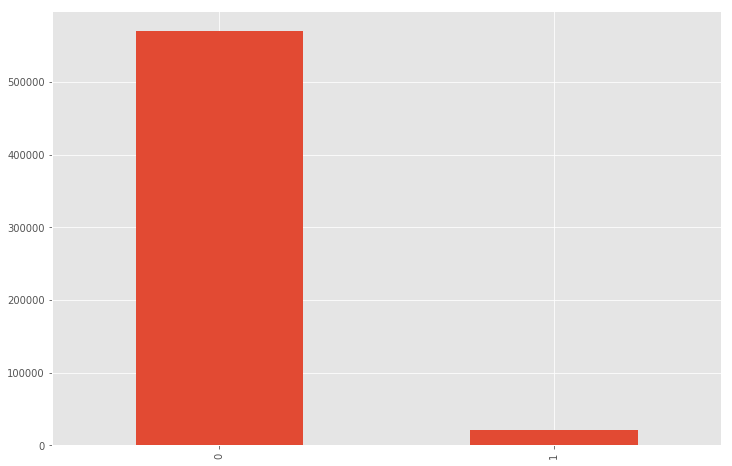

In [23]:
# plt.style.use('ggplot')
train['isFraud'].value_counts().plot('bar',figsize=(12,8))

## Time

In [24]:
# TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1

In [26]:
train['TransactionDT'].max()

15811131

In [27]:
train['TransactionDT'].min()

86400

In [28]:
train['TransactionDT'].describe()

count    5.905400e+05
mean     7.372311e+06
std      4.617224e+06
min      8.640000e+04
25%      3.027058e+06
50%      7.306528e+06
75%      1.124662e+07
max      1.581113e+07
Name: TransactionDT, dtype: float64

In [33]:
(15811131-86400)/(60*60*24*365)

0.4986279490106545

start time  unknown  
timedelta  seconds

In [ ]:
(start time) + seconds

In [ ]:
3600*24  0 
3600*24+12  12 

3600*24*2  0

3600*24*3  0

一个人  seconds 0     seconds 10000

In [34]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1

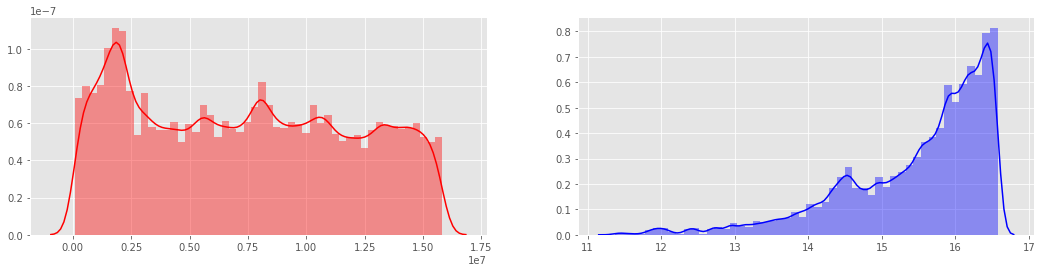

In [37]:
fix, ax = plt.subplots(1,2,figsize=(18,4))

time_val = train['TransactionDT'].values

sns.distplot(time_val, ax=ax[0],color='r')

sns.distplot(np.log(time_val), ax=ax[1],color='b')

## Train vs Test Time

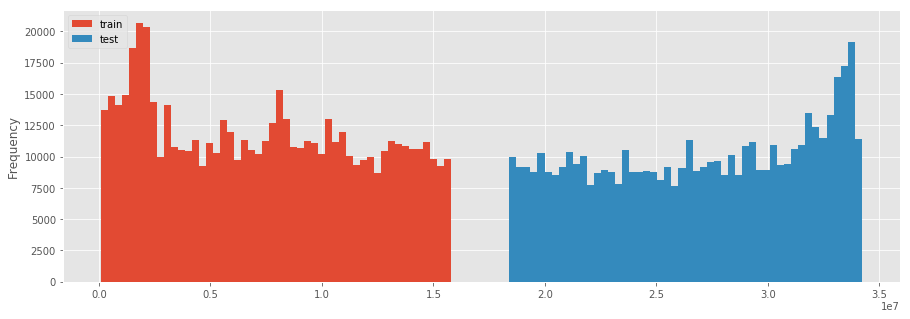

In [42]:
train['TransactionDT'].plot(kind='hist',bins=50,figsize=(15,5),label='train')
test['TransactionDT'].plot(kind='hist',bins=50,figsize=(15,5),label='test')
plt.legend()

6:train 4 cv 1

### `C`

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

trian test feature distribution

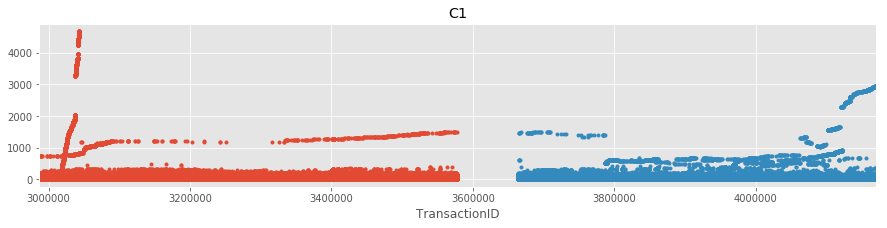

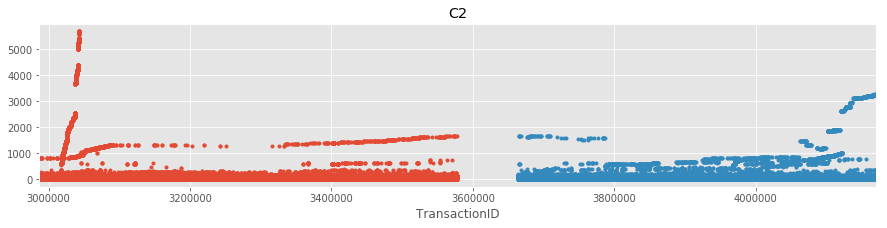

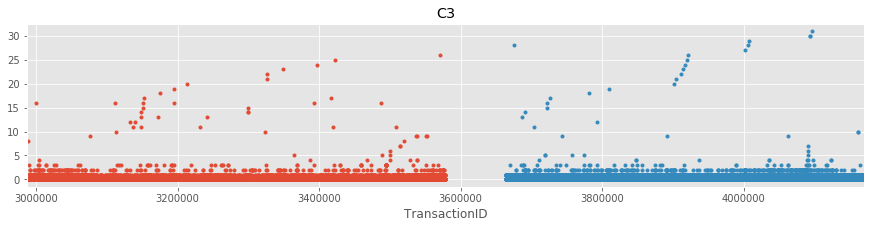

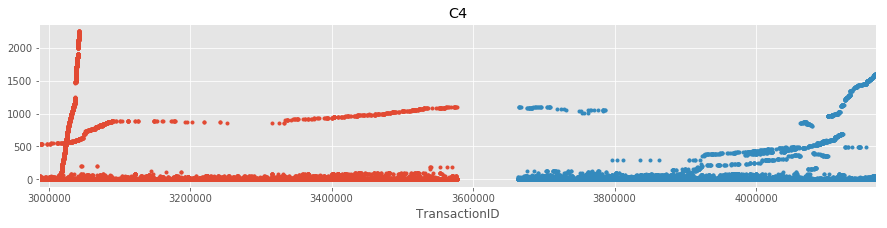

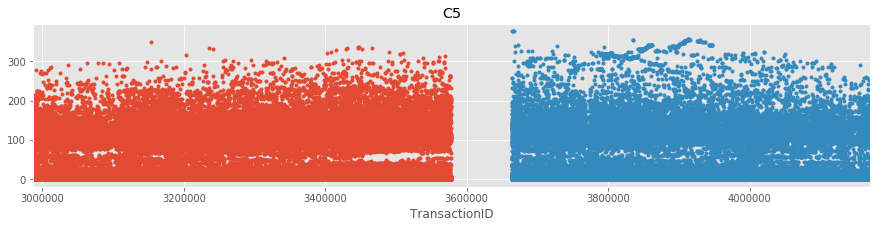

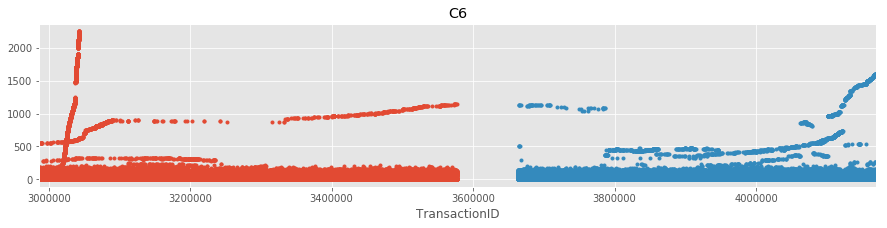

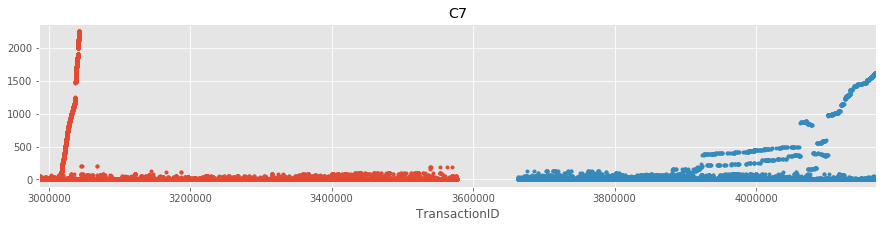

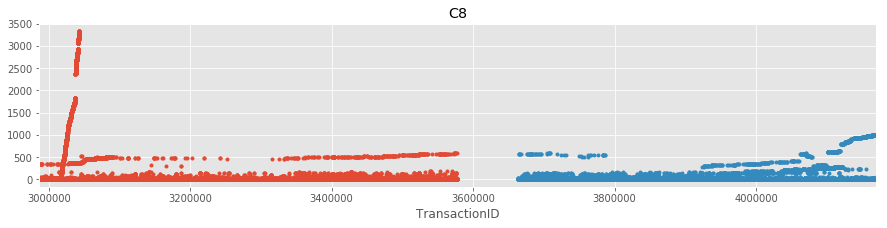

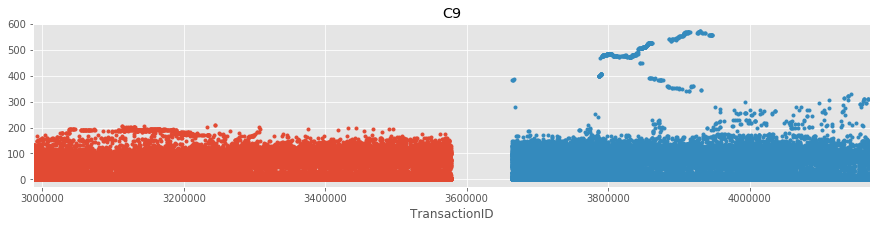

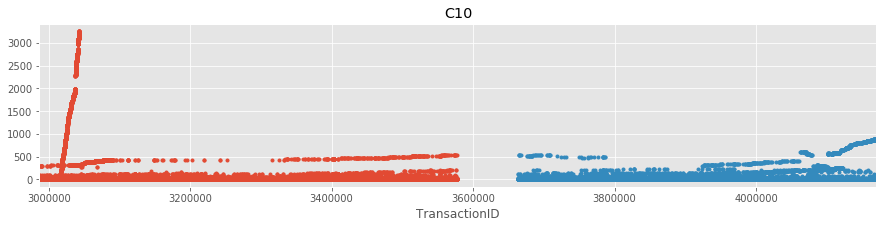

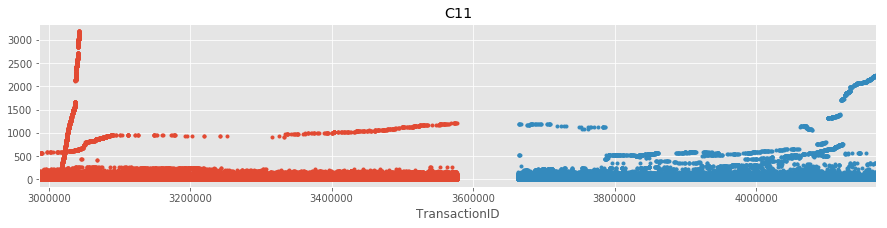

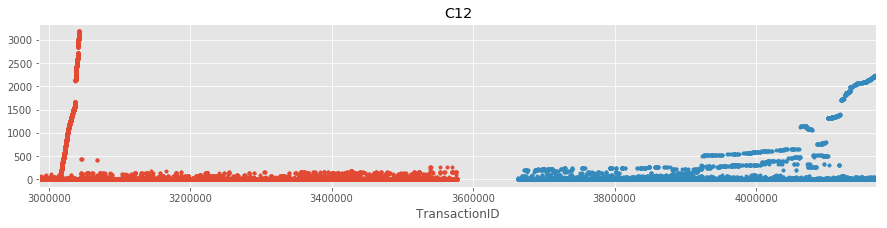

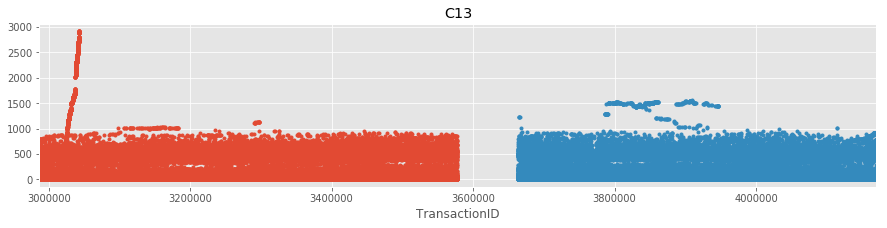

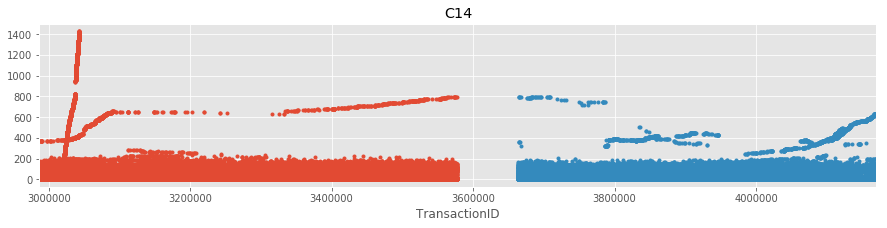

In [48]:
features = ['C'+str(i) for i in range(1,15)]

for i in features:
    train[i].plot(style='.',figsize=(15,3),title=i)
    test[i].plot(style='.',figsize=(15,3),title=i)
    plt.show()

### `D`

D1-D15: timedelta, such as days between previous transaction, etc.

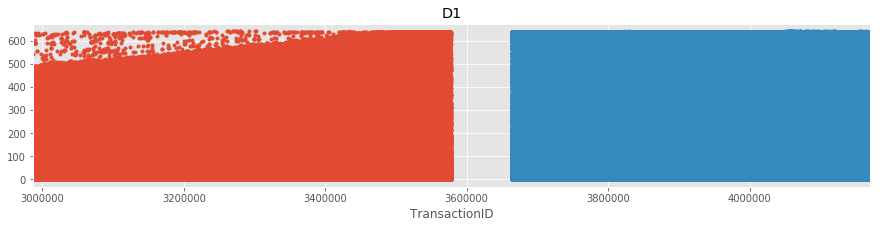

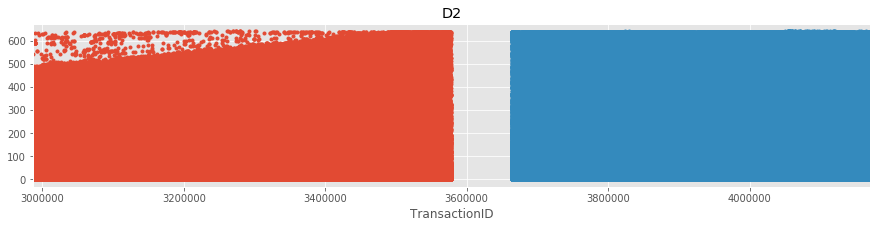

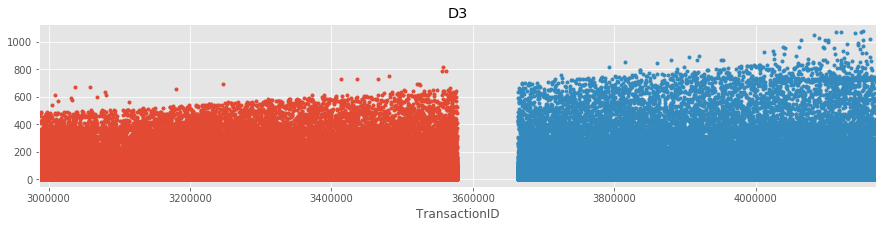

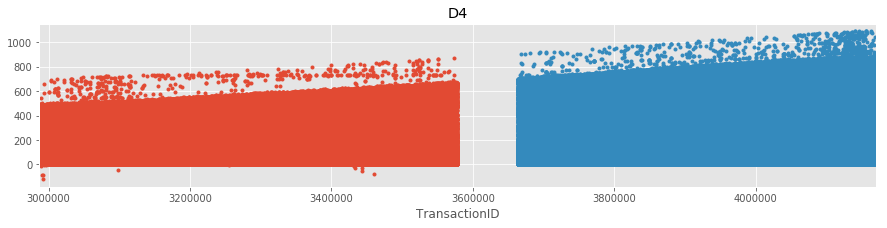

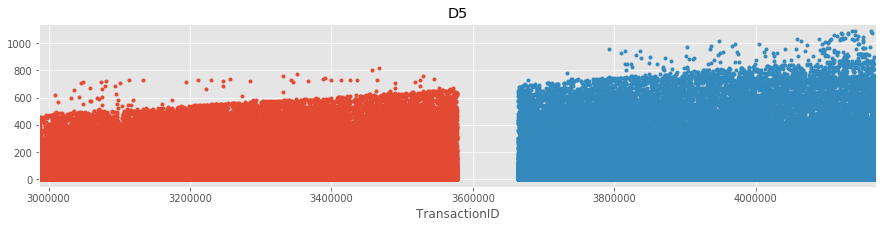

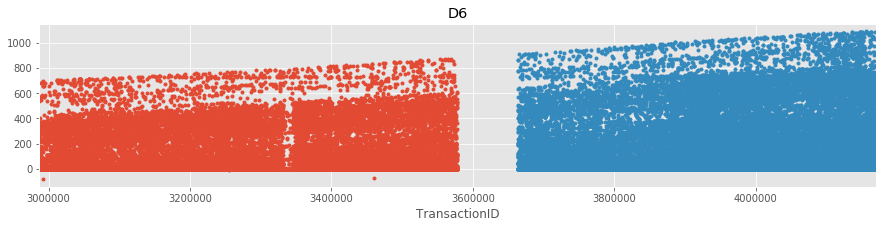

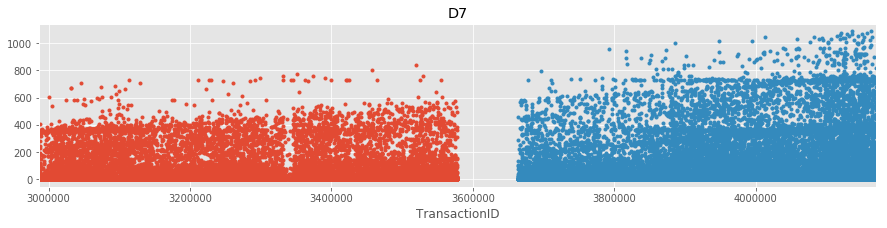

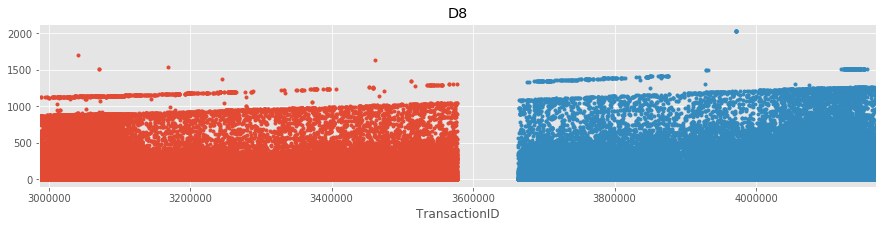

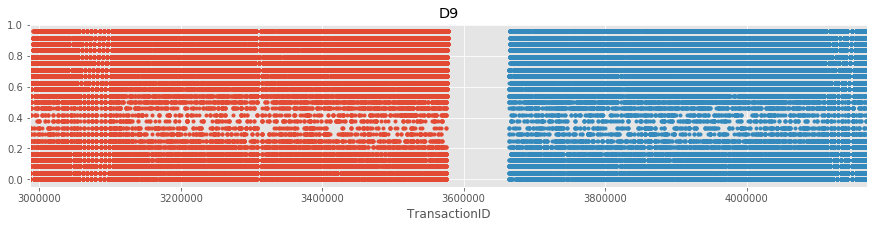

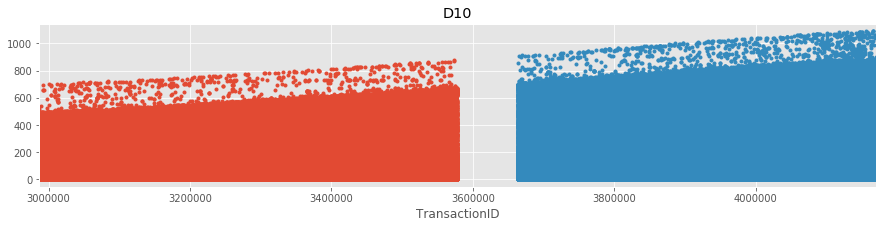

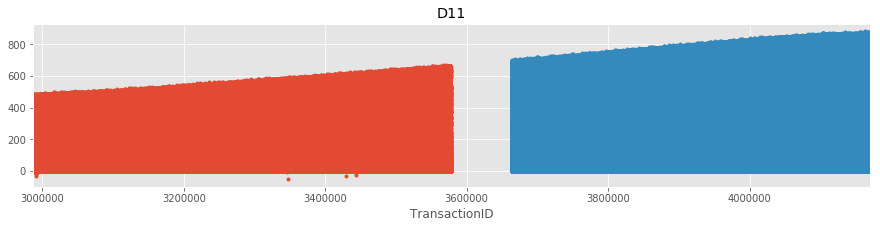

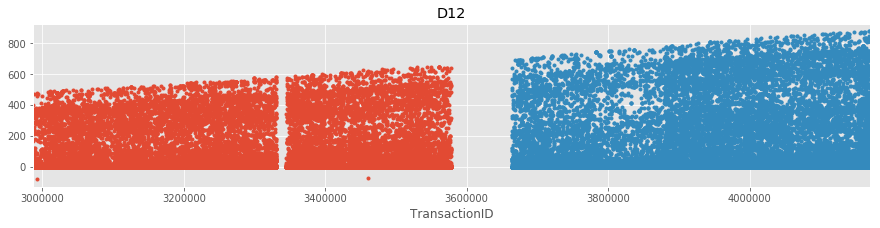

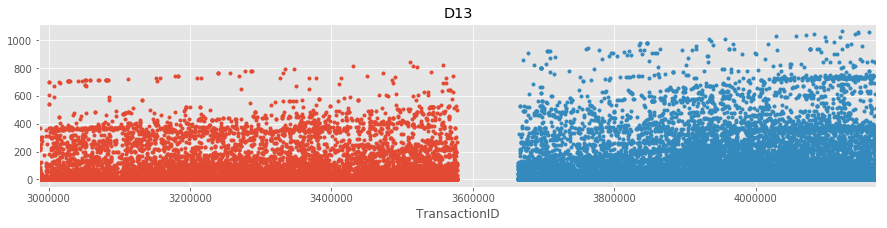

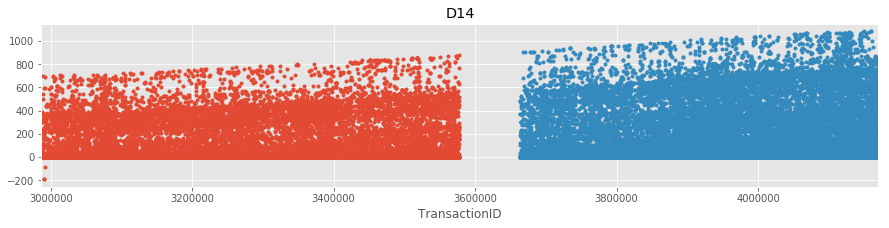

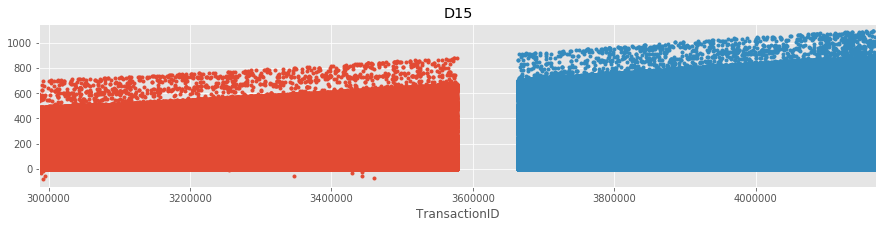

In [49]:
features = ['D'+str(i) for i in range(1,16)]

for i in features:
    train[i].plot(style='.',figsize=(15,3),title=i)
    test[i].plot(style='.',figsize=(15,3),title=i)
    plt.show()

In [51]:
train[features].isnull().sum().sum()/np.product(train[features].shape)

0.5815126268612908

信用卡欺诈：用户画像，缺失值数量，

### `M`

M1-M9: match, such as names on card and address, etc.

In [52]:
features = ['M'+str(i) for i in range(1,10)]

train[features].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,
2987000,T,T,T,M2,F,T,NaN,NaN,NaN
2987001,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2987002,T,T,T,M0,F,F,F,F,F
2987003,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
2987004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 框架

In [ ]:
# 分类变量：
## describe: size（count），unique， 
##             label_encoding: mean

# 连续变量
## time， 分箱 hist， coor， describe

In [57]:
train_id[[]].describe().reset_index()

,index,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
0,count,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,74926.000000,140978.000000,127320.000000,80044.000000,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
1,mean,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,-0.301124,99.745325,48.053071,-344.507146,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
2,std,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,2.789446,1.127602,11.774858,93.695502,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
3,min,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,-100.000000,90.000000,10.000000,-660.000000,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
4,25%,-10.000000,67992.000000,0.000000,0.000000,0.000000,-6.000000,5.000000,-48.000000,0.000000,0.000000,100.000000,49.000000,-360.000000,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
5,50%,-5.000000,125800.500000,0.000000,0.000000,0.000000,0.000000,14.000000,-34.000000,0.000000,0.000000,100.000000,52.000000,-300.000000,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
6,75%,-5.000000,228749.000000,0.000000,0.000000,1.000000,0.000000,22.000000,-23.000000,0.000000,0.000000,100.000000,52.000000,-300.000000,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
7,max,0.000000,999595.000000,10.000000,0.000000,52.000000,0.000000,61.000000,0.000000,25.000000,0.000000,100.000000,64.000000,720.000000,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


In [75]:
train = train.reset_index()
test = test.reset_index()

In [79]:
LABEL = 'isFraud'
TIME = 'TransactionDT'
ID = 'TransactionID'
AMOUNT = 'TransactionAmt'

def timehist(col):
    # clip: Assigns values outside boundary to boundary values.
    N = 8000 if col in [AMOUNT] else 9999999999999999 # clip trans amount for better view
    train[train[LABEL] == 0].set_index(TIME)[col].clip(0, N).plot(style='.', figsize=(15, 3),alpha=1)
    train[train[LABEL] == 1].set_index(TIME)[col].clip(0, N).plot(style='.', figsize=(15, 3),alpha=0.2)
    test.set_index(TIME)[col].clip(0, N).plot(style='.', title=col + ' values over time (blue=no-fraud, orange=fraud, green=test)', figsize=(15, 3))
    plt.show()
    
    
def _desc(data, col, label):
    '''
    return: count/mean/std/min/25%/50%/75%/max/unique values/NaNs/NaNs share
    '''
    d0 = data.describe().reset_index()
    d0.columns = [col, label]
    return d0.append({col:'unique values', label:data.unique().shape[0]}, ignore_index=True) \
             .append({col:'NaNs', label:data.isnull().sum()}, ignore_index=True) \
             .append({col:'NaNs share', label:np.round(data.isnull().sum() / data.shape[0], 4)}, ignore_index=True) \
    
def desc(col):
    d0 = _desc(train[col], col, 'Train')  # 训练集整体
    d1 = _desc(train.loc[train[LABEL] == 1, col], col, 'Train fraud')  # label = 1 
    d2 = _desc(train.loc[train[LABEL] == 0, col], col, 'Train Not fraud')  # label = 2
    d3 = _desc(test[col], col, 'Test')   # 测试集整体
    dd = d0.merge(d1).merge(d2).merge(d3)
    display(dd)
    
    if col not in [ID]:
        # label encoding
        N = 10
        d0 = train[[LABEL, col]].fillna(-999).groupby(col)[LABEL].agg(['size','mean','sum']).reset_index().sort_values('size', ascending=False).reset_index(drop=True)
        d1 = test[[ID,col]].fillna(-999).groupby(col)[ID].count().reset_index()
        dd = d0.merge(d1, how='left', on=col).head(N)
        dd = dd.rename({'size':'Count in train (desc)','mean':'Mean target','sum':'Sum target','TransactionID':'Count in test'}, axis=1)
        display(dd)

#         dd = d0.sort_values('sum', ascending=False).reset_index(drop=True).head(N).merge(d1, how='left', on=col)
#         dd = dd.rename({'size':'Count in train','mean':'Mean target','sum':'Sum target (desc)','TransactionID':'Count in test'}, axis=1)
#         display(dd)

def hist(col):
    plt.figure(figsize=(15, 3))
    plt.subplot(121)
    plt.hist(train[col], bins=70);
    plt.title('Train histogram: ' + col);
    plt.subplot(122)
    plt.hist(test[col], bins=70);
    plt.title('Test histogram: ' + col);
    plt.show()

def corr(col):
    '''
    return the most correlated columns
    '''
    N = None #10000
    num_vars = [f for f in train.columns if train[f].dtype != 'object']
    trx = train.head(N) if N is not None else train.copy()
    corrs = trx[num_vars].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column',0:'Correlation with ' + col}, axis=1)

    trx = pd.concat([corrs.head(6), corrs.dropna().tail(5)])
    display(trx)
    
def numeric(col):
    timehist(col)
    hist(col)
    desc(col)
#     corr(col) 
    
def categorical(col):
    desc(col)

def eda(col):
    if col not in [LABEL, TIME]:
        if train[col].dtype == 'object':
            categorical(col)
        else:
            numeric(col)
            break

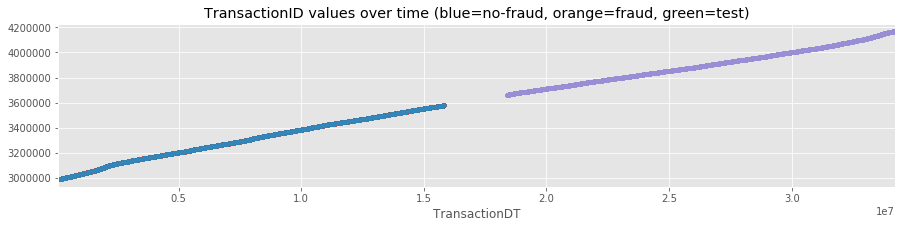

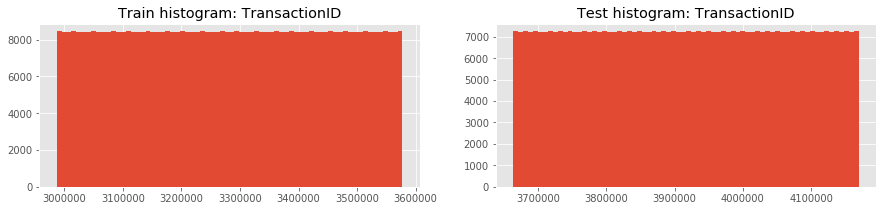

,TransactionID,Train,Train fraud,Train Not fraud,Test
0,count,5.905400e+05,2.066300e+04,5.698770e+05,5.066910e+05
1,mean,3.282270e+06,3.294952e+06,3.281810e+06,3.916894e+06
2,std,1.704744e+05,1.620403e+05,1.707548e+05,1.462692e+05
3,min,2.987000e+06,2.987203e+06,2.987000e+06,3.663549e+06
4,25%,3.134635e+06,3.167366e+06,3.133317e+06,3.790222e+06
5,50%,3.282270e+06,3.291934e+06,3.281808e+06,3.916894e+06
6,75%,3.429904e+06,3.428646e+06,3.429974e+06,4.043566e+06
7,max,3.577539e+06,3.577526e+06,3.577539e+06,4.170239e+06
8,unique values,5.905400e+05,2.066300e+04,5.698770e+05,5.066910e+05
9,NaNs,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


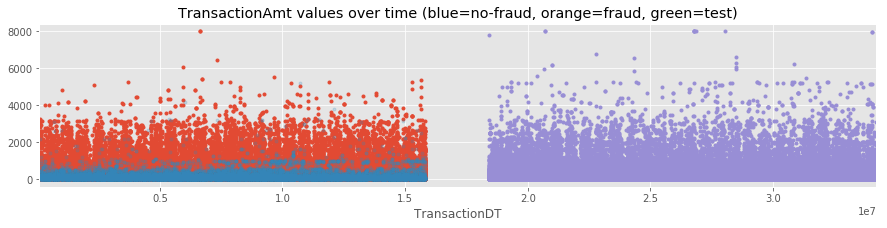

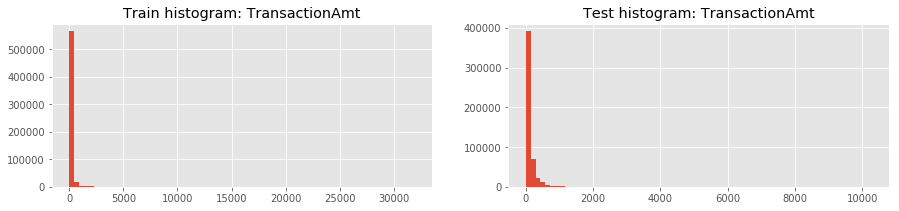

,TransactionAmt,Train,Train fraud,Train Not fraud,Test
0,count,590540.000000,20663.000000,569877.000000,506691.000000
1,mean,135.027176,149.244779,134.511665,134.725568
2,std,239.162522,232.212163,239.395078,245.779822
3,min,0.251000,0.292000,0.251000,0.018000
4,25%,43.321000,35.044000,43.970000,40.000000
5,50%,68.769000,75.000000,68.500000,67.950000
6,75%,125.000000,161.000000,120.000000,125.000000
7,max,31937.391000,5191.000000,31937.391000,10270.000000
8,unique values,20902.000000,2515.000000,20560.000000,14119.000000
9,NaNs,0.000000,0.000000,0.000000,0.000000


,TransactionAmt,Count in train (desc),Mean target,Sum target,Count in test
0,59.00,30582,0.021124,646,27365.0
1,117.00,28933,0.024851,719,25798.0
2,107.95,23954,0.009226,221,20243.0
3,57.95,23600,0.003814,90,20063.0
4,100.00,20362,0.025685,523,17565.0
5,50.00,17009,0.020754,353,14469.0
6,49.00,15990,0.029331,469,14231.0
7,226.00,11704,0.033322,390,11084.0
8,39.00,11095,0.021812,242,9926.0
9,29.00,10683,0.018815,201,9019.0


,ProductCD,Train,Train fraud,Train Not fraud,Test
0,count,590540,20663,569877,506691
1,unique,5,5,5,5
2,top,W,W,W,W
3,freq,439670,8969,430701,360987
4,unique values,5,5,5,5
5,NaNs,0,0,0,0
6,NaNs share,0,0,0,0


,ProductCD,Count in train (desc),Mean target,Sum target,Count in test
0,W,439670,0.020399,8969,360987
1,C,68519,0.116873,8008,69266
2,R,37699,0.037826,1426,35647
3,H,33024,0.047662,1574,29373
4,S,11628,0.058996,686,11418


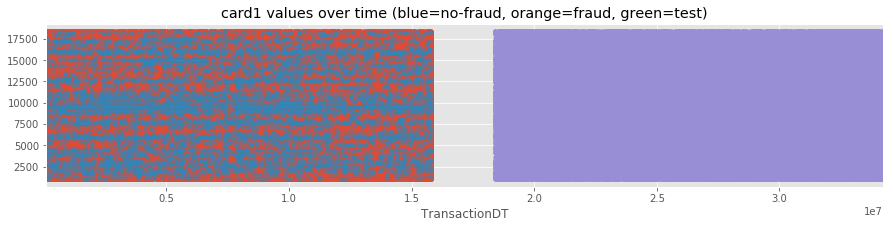

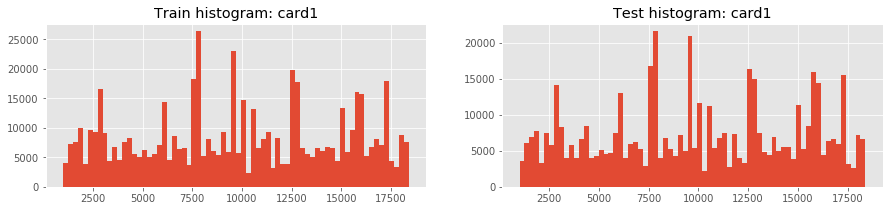

,card1,Train,Train fraud,Train Not fraud,Test
0,count,590540.000000,20663.000000,569877.000000,506691.000000
1,mean,9898.734658,9547.654164,9911.464381,9957.222175
2,std,4901.170153,4762.051380,4905.672370,4884.960969
3,min,1000.000000,1015.000000,1000.000000,1001.000000
4,25%,6019.000000,5732.500000,6019.000000,6019.000000
5,50%,9678.000000,9633.000000,9711.000000,9803.000000
6,75%,14184.000000,13623.000000,14229.000000,14276.000000
7,max,18396.000000,18375.000000,18396.000000,18397.000000
8,unique values,13553.000000,1740.000000,13350.000000,13244.000000
9,NaNs,0.000000,0.000000,0.000000,0.000000


,card1,Count in train (desc),Mean target,Sum target,Count in test
0,7919,14932,0.007501,112,13083.0
1,9500,14162,0.037283,528,12081.0
2,15885,10361,0.042853,444,12330.0
3,17188,10344,0.026875,278,9262.0
4,15066,7945,0.039396,313,6661.0
5,12695,7091,0.028346,201,5641.0
6,12544,6773,0.021556,146,5921.0
7,6019,6771,0.043420,294,6497.0
8,2803,6141,0.011887,73,4902.0
9,7585,5334,0.049306,263,4763.0


KeyboardInterrupt: 

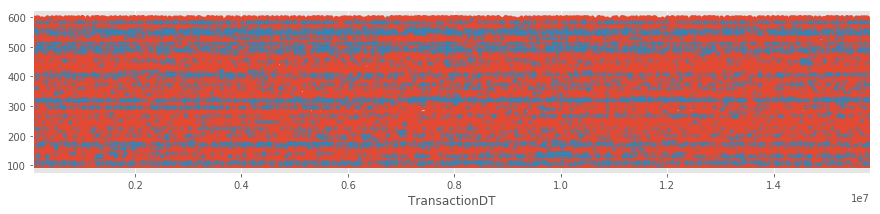

In [80]:
for i in train.columns:
    eda(i)